In [441]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [442]:
# Imports
import pandas as pd
import numpy
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np

In [496]:
# load cvs into pands dataframe
df = pd.read_csv('data.csv')
df = df.drop(['date', 'timestamp'], axis=1)
df.describe()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


In [497]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   day_of_week           62184 non-null  int64  
 2   is_weekend            62184 non-null  int64  
 3   is_holiday            62184 non-null  int64  
 4   temperature           62184 non-null  float64
 5   is_start_of_semester  62184 non-null  int64  
 6   is_during_semester    62184 non-null  int64  
 7   month                 62184 non-null  int64  
 8   hour                  62184 non-null  int64  
dtypes: float64(1), int64(8)
memory usage: 4.3 MB


In [498]:
#standardize data
pop_mean = df["number_people"].mean()
pop_std = df["number_people"].std()

# print percentiles
print(df["number_people"].quantile([0, 0.33, 0.67,1]))
df["number_people"] = (df["number_people"] - df["number_people"].mean()) / df["number_people"].std()
df["temperature"] = (df["temperature"] - df["temperature"].mean()) / df["temperature"].std()

#one hot encoding day of week
df = pd.get_dummies(df, columns=["day_of_week"])

#one hot encoding month
df = pd.get_dummies(df, columns=["month"])

df.head()


0.00      0.0
0.33     18.0
0.67     38.0
1.00    145.0
Name: number_people, dtype: float64


,number_people,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,hour,day_of_week_0,day_of_week_1,day_of_week_2,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,0.349396,0,0,2.090257,0,0,17,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0.701989,0,0,2.090257,0,0,17,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0.481619,0,0,2.090257,0,0,17,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.657915,0,0,2.090257,0,0,17,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0.701989,0,0,2.090257,0,0,17,0,0,0,...,0,0,0,0,0,1,0,0,0,0


<AxesSubplot:>

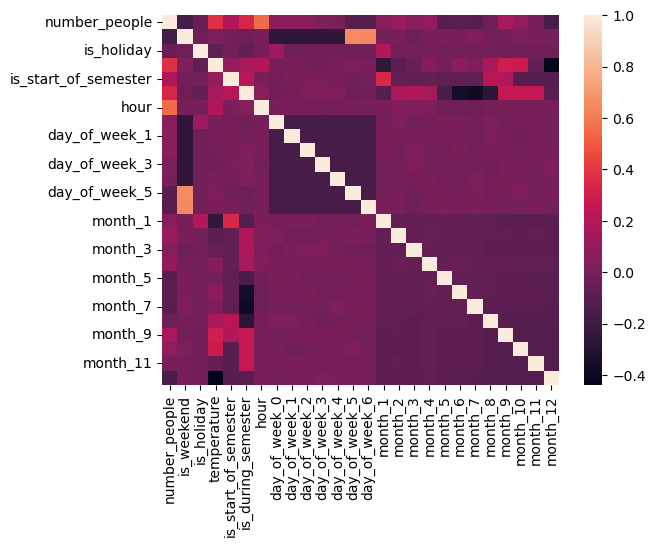

In [499]:
corr = df.corr()
sns.heatmap(corr)


In [513]:
#select features based on correlation matrix
all_features = df.drop(['number_people'], axis=1).columns
print('total features:',len(all_features))
selected_features = []
for feature in all_features:
    if abs(corr.loc[feature, 'number_people']) > 0.07:
        selected_features.append(feature)

selected_features
print('selected features:',len(selected_features))

total features: 25
selected features: 15


In [501]:
# try to predict number of people using linear regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

#split data into train and test
X_train, X_test, Y_train, Y_test = train_test_split(df[selected_features], df['number_people'], test_size=0.1, random_state=42)

ln = LinearRegression()
ln.fit(X_train, Y_train)

pred = ln.predict(X_test)

# mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, pred))

# r2 score
print('Variance score: %.2f' % r2_score(Y_test, pred))


Mean squared error: 0.49
Variance score: 0.52


In [502]:
print(Y_test.shape)

(6219,)


In [503]:
# try to predict number of people using torch neural network

train_data = data.TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(Y_train.values, dtype=torch.float))
test_data = data.TensorDataset(torch.tensor(X_test.values, dtype=torch.float), torch.tensor(Y_test.values, dtype=torch.float))

train_loader = data.DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=100, shuffle=True)

In [504]:
# define neural network
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

class Net(nn.Module):
    def __init__(self, conf, classifications=1):
        super(Net, self).__init__()
        self.model = self.build_model(conf, classifications)

    def forward(self, X):
        return self.model(X)

    def build_model(self, conf, classifications=1):
        layers = []
        input_size = X_train.shape[1]
        for l in conf:
            if l == 'R':
                layers.append(nn.ReLU())
            elif l == 'D':
                layers.append(nn.Dropout(0.2))
            elif l == 'B':
                layers.append(nn.BatchNorm1d(input_size))
            else:
                layers.append(nn.Linear(input_size, l))
                input_size = l
        
        layers += [nn.Linear(input_size, classifications)]
        if classifications > 1:
            layers += [nn.Softmax(dim=1)]
        return nn.Sequential(*layers)

conf = [32, 'B', 'R', 'D', 32, 'B', 'R', 'D', 10, 'B', 'R']
net = Net(conf)
print(net)

cuda
Net(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=10, out_features=1, bias=True)
  )
)


In [505]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=.0001, weight_decay=.00001)
start_epoch = 0
resume = True
name = 'dense_net'
training_loss_arr = []
testing_loss_arr = []
best_loss = None
classifications = False
# torch.autograd.set_detect_anomaly(True)



def train(epoch, classifications=False):
    tr_loss = 0
    net.train()
    for index, (input, target) in enumerate(train_loader):
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        pred = net(input)
        if not classifications:
            pred = pred.view(-1)
        loss = criterion(pred, target)
        loss.backward()
        optimizer.step()

        tr_loss += loss.item()
        print(f'epoch: {epoch}  /  batch: {index}  /  loss {loss.item()}', end='\r')

    training_loss_arr.append(tr_loss)


def test(epoch, classifications=False):
    ts_loss = 0 
    global best_loss
    net.eval()
    with torch.no_grad():
        for input, target in test_loader:
            input, target = input.to(device), target.to(device)
            pred = net(input)
            if not classifications:
                pred = pred.view(-1)
            loss = criterion(pred, target)
            ts_loss += loss.item()
    testing_loss_arr.append(ts_loss)
    print(f'epoch: {epoch}  /  test loss {ts_loss}                  ')

    if best_loss is not None and ts_loss < best_loss:
        state = {
            'net' : net.state_dict(),
            'loss' : ts_loss,
            'epoch' : epoch
        }
        torch.save(state, f'checkpoint/{name}.pth')
        best_loss = ts_loss
    elif best_loss == None:
        state = {
            'net' : net.state_dict(),
            'loss' : ts_loss,
            'epoch' : epoch
        }
        torch.save(state, f'checkpoint/{name}.pth')
        best_loss = ts_loss

if resume:
    checkpoint = torch.load(f'checkpoint/{name}.pth')
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    net.load_state_dict(checkpoint['net'])

net.to(device)
# for e in range(start_epoch, 200):
#     train(e)
#     test(e)

Net(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=10, out_features=1, bias=True)
  )
)

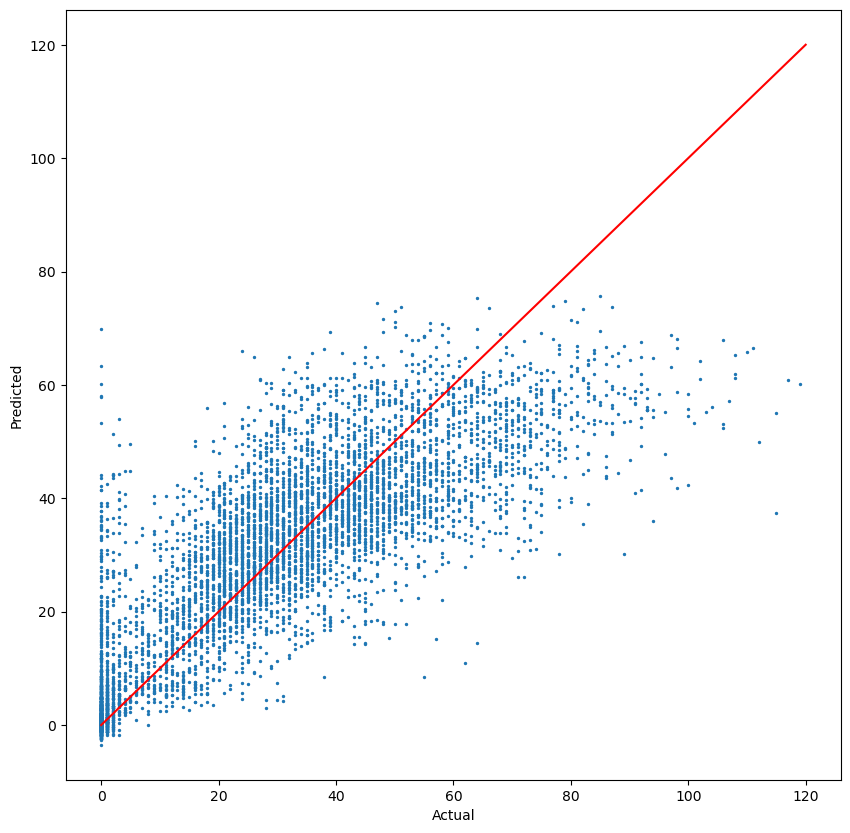

In [506]:
# display predictions and actual values
checkpoint = torch.load(f'checkpoint/{name}.pth')
net.load_state_dict(checkpoint['net'])
net.to('cpu')
pred = net(torch.tensor(X_test.values, dtype=torch.float)).view(-1).detach().numpy()
pred = pred*pop_std + pop_mean
Y_test = Y_test*pop_std + pop_mean
plt.figure(figsize=(10, 10))
plt.scatter(Y_test, pred, s=2)
plt.ylabel('Predicted')
plt.xlabel('Actual')
#plot y=x line
plt.plot([0, 120], [0, 120], color='red')

In [507]:
random_samp = np.random.randint(0, len(X_test), 10)
print('Predictions of people in gym / actual number of people in gym')
for i in random_samp:
    print(f'prediction: {round(pred[i])}  /  actual: {round(Y_test.iloc[i])}')

Predictions of people in gym / actual number of people in gym
prediction: 50  /  actual: 67
prediction: 7  /  actual: 2
prediction: 17  /  actual: 7
prediction: 55  /  actual: 64
prediction: 27  /  actual: 35
prediction: -1  /  actual: 0
prediction: 29  /  actual: 36
prediction: 7  /  actual: 0
prediction: 38  /  actual: 47
prediction: 52  /  actual: 42


In [508]:
# bin into not crowded, crowded, and very crowded
bins = [-5,20,40,150]
labels = [0,1,2]
pred_binned = pd.cut(pred, bins=bins, labels=labels)
Y_test_binned = pd.cut(Y_test, bins=bins, labels=labels)

In [509]:
# show accuracy
from sklearn.metrics import accuracy_score
print('Accuracy: ', accuracy_score(Y_test_binned, pred_binned))

# show confusion matrix
from sklearn.metrics import confusion_matrix
print('Confusion matrix: ')
print(confusion_matrix(Y_test_binned, pred_binned))

Accuracy:  0.710725196977006
Confusion matrix: 
[[1725  475   54]
 [ 166 1425  526]
 [  22  556 1270]]


In [510]:
# retrain model with bins

net = Net(conf, classifications=3)
print(net)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=.0001, weight_decay=.00001)
name = 'dense_net_binned'
best_loss = None
resume = True
start_epoch = 0
if resume:
    checkpoint = torch.load(f'checkpoint/{name}.pth')
    start_epoch = checkpoint['epoch']
    best_loss = checkpoint['loss']
    net.load_state_dict(checkpoint['net'])

net.to(device)
Y_train_binned = pd.cut(Y_train*pop_std + pop_mean, bins=bins, labels=labels)
Y_test_binned = pd.cut(Y_test, bins=bins, labels=labels)

train_data = data.TensorDataset(torch.tensor(X_train.values, dtype=torch.float), torch.tensor(Y_train_binned.values, dtype=torch.long))
test_data = data.TensorDataset(torch.tensor(X_test.values, dtype=torch.float), torch.tensor(Y_test_binned.values, dtype=torch.long))

train_loader = data.DataLoader(train_data, batch_size=300, shuffle=True)
test_loader = data.DataLoader(test_data, batch_size=100, shuffle=False)


# for e in range(start_epoch, 200):
#     train(e, classifications=True)
#     test(e, classifications=True)

Net(
  (model): Sequential(
    (0): Linear(in_features=15, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=32, out_features=10, bias=True)
    (9): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Linear(in_features=10, out_features=3, bias=True)
    (12): Softmax(dim=1)
  )
)


In [511]:
# display predictions and actual values
checkpoint = torch.load(f'checkpoint/{name}.pth')
net.load_state_dict(checkpoint['net'])
net.to('cpu')

pred = net(torch.tensor(X_test.values, dtype=torch.float)).detach().numpy()
pred = np.argmax(pred, axis=1)
Y_binned = Y_test_binned.values
Y_binned.to_numpy()
print('Confusion matrix')
conf_matrix = sklearn.metrics.confusion_matrix(Y_binned, pred)
print(conf_matrix)

Confusion matrix
[[1835  346   73]
 [ 256 1373  488]
 [  53  514 1281]]


In [512]:
# get random sample and show predictions and actual
random_samp = np.random.randint(0, len(X_test), 15)
label = ['empty', 'sparse', 'crowded']
print('Predictions of crowd size / actual crowd size')
for i in random_samp:
    print(f'prediction: {label[round(pred[i])]}  /  actual: {label[round(Y_binned[i])]}')

Predictions of crowd size / actual crowd size
prediction: crowded  /  actual: sparse
prediction: empty  /  actual: empty
prediction: empty  /  actual: empty
prediction: crowded  /  actual: crowded
prediction: empty  /  actual: empty
prediction: sparse  /  actual: sparse
prediction: sparse  /  actual: sparse
prediction: empty  /  actual: crowded
prediction: crowded  /  actual: crowded
prediction: empty  /  actual: sparse
prediction: empty  /  actual: empty
prediction: crowded  /  actual: crowded
prediction: sparse  /  actual: sparse
prediction: sparse  /  actual: sparse
prediction: crowded  /  actual: crowded


In [514]:
# accuracy
print('Accuracy: ', accuracy_score(Y_binned, pred))

Accuracy:  0.7218202283325293
